In [350]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


In [351]:
file_path = "house_price.csv"

df = pd.read_csv(file_path, index_col=0)
df.reset_index(inplace=True)

In [352]:
df = df.drop(columns=['Address', 'HouseType', 'PostalCode', 'Parking', 'SoldDate'])

## Fill N/A
df["FloodPlain"] = df["FloodPlain"].fillna("No")
df["View"] = df["View"].fillna("No")
df["DepthSizeFt"] = df["DepthSizeFt"].ffill().bfill()
df["Suite"] = df["Suite"].fillna("No")
df["Basement"] = df["Basement"].fillna("No")

## Convert Values into Booleans
df.loc[df["Suite"].str.contains("Suite"), 'Suite'] = "Yes"
df.loc[df["Suite"].str.contains("Other"), 'Suite'] = "No"
df.loc[df["Basement"].str.contains("Full"), 'Basement'] = "Yes"
df.loc[df["Basement"].str.contains("Crawl"), 'Basement'] = "Yes"
df.loc[df["Basement"].str.contains("Separate"), 'Basement'] = "Yes"
df.loc[df["Basement"].str.contains("Finished"), 'Basement'] = "Yes"
df.loc[df["Basement"].str.contains("Part"), 'Basement'] = "Yes"

df

,SalePrice,Bedrooms,Bathrooms,YearBuilt,Age,LotAreaSqft,FloodPlain,View,FrontageFt,DepthSizeFt,FinishedFloorTotalSqft,Suite,Basement,NumberOfLevels,NumberOfRooms
0,"$950,000",4,2,1957,63,"4,560.00",No,No,40.00,114.00,"2,216",No,Yes,2,8
1,"$1,000,000",5,3,1948,71,"6,100.00",No,No,50.00,122.00,"2,630",Yes,Yes,3,11
2,"$1,120,000",2,1,1952,68,"4,982.00",No,No,47.00,106.00,700,No,No,1,4
3,"$1,160,000",5,2,1949,71,"6,600.00",No,No,55.00,120.00,"2,096",Yes,No,2,17
4,"$1,200,000",5,3,1981,39,0.00,No,Yes,47.00,106.00,"3,522",Yes,No,2,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,"$2,570,000",7,6,2012,12,"6,000.00",No,No,50.00,120.00,"3,566",Yes,Yes,3,15
102,"$2,690,000",6,5,2014,8,"6,360.00",No,No,53.00,120.00,"3,103",Yes,No,2,16
103,"$2,910,000",6,5,2017,6,"6,533.00",No,No,68.52,95.01,"3,865",Yes,Yes,3,17
104,"$2,998,800",6,5,2017,5,"5,550.00",No,No,50.00,111.00,"3,350",Yes,Yes,3,15


In [353]:
## Feature engineering (add 2 new ratio)
df["BathroomToRoomRatio"] = round(df["Bathrooms"] / df["NumberOfRooms"], 2)
df["BedroomToRoomRatio"] = round(df["Bedrooms"] / df["NumberOfRooms"], 2)

In [354]:
df.isnull().sum()


SalePrice                 0
Bedrooms                  0
Bathrooms                 0
YearBuilt                 0
Age                       0
LotAreaSqft               0
FloodPlain                0
View                      0
FrontageFt                0
DepthSizeFt               0
FinishedFloorTotalSqft    0
Suite                     0
Basement                  0
NumberOfLevels            0
NumberOfRooms             0
BathroomToRoomRatio       0
BedroomToRoomRatio        0
dtype: int64

In [355]:
## Convert SalePrice to float
df["SalePrice"] = df["SalePrice"].str.replace("$", "")
df["SalePrice"] = df["SalePrice"].str.replace(",", "").astype(float)

## Convert LotAreaSqft to float
df["LotAreaSqft"] = df["LotAreaSqft"].str.replace(",", "").astype(float)
df["FinishedFloorTotalSqft"] = df["FinishedFloorTotalSqft"].str.replace(",", "").astype(float)

In [356]:
df

,SalePrice,Bedrooms,Bathrooms,YearBuilt,Age,LotAreaSqft,FloodPlain,View,FrontageFt,DepthSizeFt,FinishedFloorTotalSqft,Suite,Basement,NumberOfLevels,NumberOfRooms,BathroomToRoomRatio,BedroomToRoomRatio
0,950000.0,4,2,1957,63,4560.0,No,No,40.00,114.00,2216.0,No,Yes,2,8,0.25,0.50
1,1000000.0,5,3,1948,71,6100.0,No,No,50.00,122.00,2630.0,Yes,Yes,3,11,0.27,0.45
2,1120000.0,2,1,1952,68,4982.0,No,No,47.00,106.00,700.0,No,No,1,4,0.25,0.50
3,1160000.0,5,2,1949,71,6600.0,No,No,55.00,120.00,2096.0,Yes,No,2,17,0.12,0.29
4,1200000.0,5,3,1981,39,0.0,No,Yes,47.00,106.00,3522.0,Yes,No,2,16,0.19,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2570000.0,7,6,2012,12,6000.0,No,No,50.00,120.00,3566.0,Yes,Yes,3,15,0.40,0.47
102,2690000.0,6,5,2014,8,6360.0,No,No,53.00,120.00,3103.0,Yes,No,2,16,0.31,0.38
103,2910000.0,6,5,2017,6,6533.0,No,No,68.52,95.01,3865.0,Yes,Yes,3,17,0.29,0.35
104,2998800.0,6,5,2017,5,5550.0,No,No,50.00,111.00,3350.0,Yes,Yes,3,15,0.33,0.40


In [357]:
## Encode Categorical Values into Numeric Values
encoder = LabelEncoder()
df["FloodPlain"] = encoder.fit_transform(df["FloodPlain"])
df["View"] = encoder.fit_transform(df["View"])
df["Suite"] = encoder.fit_transform(df["Suite"])
df["Basement"] = encoder.fit_transform(df["Basement"])

In [358]:
df

,SalePrice,Bedrooms,Bathrooms,YearBuilt,Age,LotAreaSqft,FloodPlain,View,FrontageFt,DepthSizeFt,FinishedFloorTotalSqft,Suite,Basement,NumberOfLevels,NumberOfRooms,BathroomToRoomRatio,BedroomToRoomRatio
0,950000.0,4,2,1957,63,4560.0,0,0,40.00,114.00,2216.0,0,1,2,8,0.25,0.50
1,1000000.0,5,3,1948,71,6100.0,0,0,50.00,122.00,2630.0,1,1,3,11,0.27,0.45
2,1120000.0,2,1,1952,68,4982.0,0,0,47.00,106.00,700.0,0,0,1,4,0.25,0.50
3,1160000.0,5,2,1949,71,6600.0,0,0,55.00,120.00,2096.0,1,0,2,17,0.12,0.29
4,1200000.0,5,3,1981,39,0.0,0,1,47.00,106.00,3522.0,1,0,2,16,0.19,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2570000.0,7,6,2012,12,6000.0,0,0,50.00,120.00,3566.0,1,1,3,15,0.40,0.47
102,2690000.0,6,5,2014,8,6360.0,0,0,53.00,120.00,3103.0,1,0,2,16,0.31,0.38
103,2910000.0,6,5,2017,6,6533.0,0,0,68.52,95.01,3865.0,1,1,3,17,0.29,0.35
104,2998800.0,6,5,2017,5,5550.0,0,0,50.00,111.00,3350.0,1,1,3,15,0.33,0.40


<Axes: >

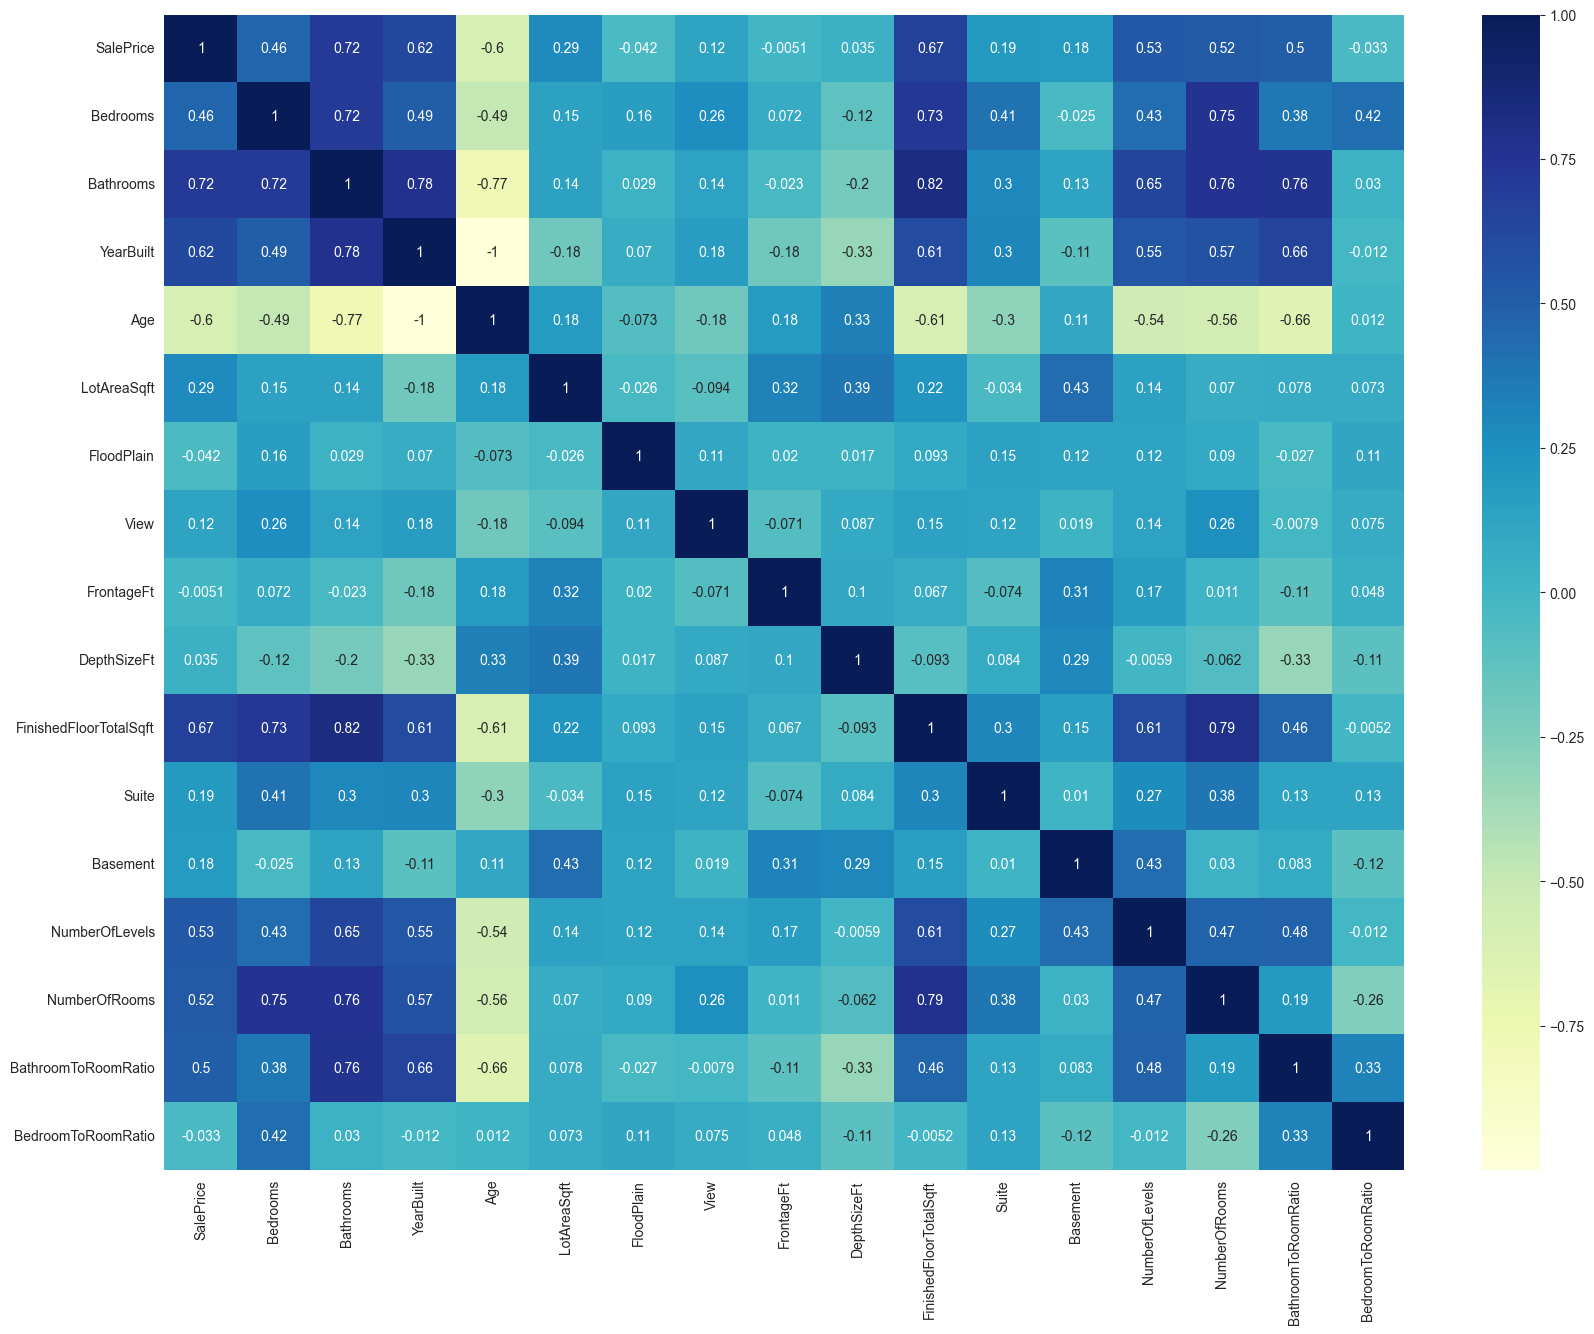

In [359]:
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")


In [360]:
## Features
X = df.drop(["SalePrice"], axis=1)

## Target Variable
y = df["SalePrice"]

In [361]:
## Split Train set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

In [362]:
## Initiate Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [363]:
## Make Prediction
y_pred = model.predict(X_test)

In [364]:
## Performance Scores
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'RMSE: {rmse}')

Mean Squared Error: 38150461479.51175
R^2 Score: 0.7197657795476642
RMSE: 195321.43118334902
